# Маркетинг

## Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

В данном проекте выполним следующее:
<br>
● Изучим данные
<br>
● Разработаем полезные признаки
<br>
● Создадим модель для классификации пользователей
<br>
● Улучшим модель и максимизируем метрику roc_auc
<br>
● Выполним тестирование

Имеются 3 датасета: apparel-purchases - (история покупок, которая содержит айди клиента, цена товара, количество и категория товара и идентификатор сообщения), apparel-messages (история рассылок, которая содержит идентификатор пользователя, идентификатор сообщений, тип действия, канал рассылки, дата рассылки сообщения, а так же точное время создания сообщения), apparel-target_binary (содержит таргет: совершит ли клиент покупку в течение следующих 90 дней)

## Библиотеки

In [1]:
!pip install phik -q
!pip install matplotlib==3.5.1 -q
!pip install scikit-learn --upgrade -q
!pip install lightgbm -q
!pip install catboost -q
!pip install category_encoders -q
!pip install imblearn -q

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier

from scipy import stats as st
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from category_encoders import BinaryEncoder
from sklearn.metrics import roc_auc_score

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Обзор данных

In [3]:
purchases = pd.read_csv('./apparel-purchases.csv')

In [4]:
messages = pd.read_csv('./apparel-messages.csv')

In [5]:
target = pd.read_csv('./apparel-target_binary.csv')

### purchases

In [6]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [7]:
purchases.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [8]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


#### Типы данных

Поменяем тип данных для date на datetime

In [9]:
purchases['date'] = pd.to_datetime(purchases['date'])

In [10]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


### messages

In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [12]:
messages.describe()

,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,1.329704e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18


In [13]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


#### Типы данных

Приведем столбцы date и created_at к типу данных datetime

In [14]:
for i in ['date', 'created_at']:
    messages[i] = pd.to_datetime(messages[i])

In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


### target

In [16]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [17]:
target.describe()

,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


In [18]:
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


## Агрегирование данных

Итак, нам нужно проверить совершит ли покупатель покупку, поэтому нам необходимо сагрегировать по уникальным пользователям из файла таргет. 

### Проверка пользователей

In [19]:
len(purchases['client_id'].unique())

49849

In [20]:
len(target['client_id'].unique())

49849

In [21]:
check = pd.merge(pd.DataFrame(purchases['client_id'].unique(), columns=['client_id']), pd.DataFrame(target['client_id'].unique(), columns=['client_id']), how='outer', on='client_id')

In [22]:
check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
dtypes: int64(1)
memory usage: 778.9 KB


Видим, что все пользователи в таргет совершали покупки

### Формирование признаков из purchase

Мы не можем делать дублирование по client_id, поэтому нам необходимо сагрегировать покупки так, чтобы была максимально полезная инфа для предсказания

In [23]:
df = target.copy()

найдём, сколько тратилось за одну покупку (кол * цену)

In [24]:
purchases['money_spend'] = purchases['price'] * purchases['quantity']

In [25]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,money_spend
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,6499.0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0


Найдём суммарно потраченные деньги клиентами

In [26]:
price_sum = pd.DataFrame(purchases.groupby('client_id')['money_spend'].sum()).reset_index()
price_sum.columns = ['client_id', 'price_sum']

In [27]:
price_sum.head()

,client_id,price_sum
0,1515915625468060902,6993.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0
3,1515915625468061100,2098.0
4,1515915625468061170,33601.0


Найдём сколько всего было покупок у клиентов

In [28]:
count_purch = pd.DataFrame(purchases.groupby('client_id')['price'].count()).reset_index()
count_purch.columns = ['client_id', 'count_purch']

In [29]:
count_purch.head()

,client_id,count_purch
0,1515915625468060902,7
1,1515915625468061003,7
2,1515915625468061099,1
3,1515915625468061100,2
4,1515915625468061170,19


Найдём саммые популярные категории товаров у клиентов

In [30]:
mode_cat = pd.DataFrame(purchases.groupby('client_id')['category_ids'].agg(lambda x:x.value_counts().index[0])).reset_index()
mode_cat.columns = ['client_id', 'mode_cat']

In [31]:
mode_cat.head()

,client_id,mode_cat
0,1515915625468060902,"['4', '27', '176', '458']"
1,1515915625468061003,"['4', '28', '249', '615']"
2,1515915625468061099,"['4', '28', '290', '424']"
3,1515915625468061100,"['4', '27', '1828', '5717']"
4,1515915625468061170,"['4', '28', '260', '420']"


Теперь найдём последние покупки клиентов

In [32]:
last_groupby = purchases.loc[purchases.groupby('client_id')['date'].idxmax()]

In [33]:
last_groupby.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 3695 to 202207
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   client_id     49849 non-null  int64         
 1   quantity      49849 non-null  int64         
 2   price         49849 non-null  float64       
 3   category_ids  49849 non-null  object        
 4   date          49849 non-null  datetime64[ns]
 5   message_id    49849 non-null  object        
 6   money_spend   49849 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 3.0+ MB


In [34]:
last_groupby.drop(columns=['quantity', 'price'], inplace=True)

In [35]:
last_groupby.columns = ['client_id', 'last_buy_cats', 'last_buy_date', 'message_id', 'last_buy_money_spend']

In [36]:
last_groupby.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 3695 to 202207
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49849 non-null  int64         
 1   last_buy_cats         49849 non-null  object        
 2   last_buy_date         49849 non-null  datetime64[ns]
 3   message_id            49849 non-null  object        
 4   last_buy_money_spend  49849 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.3+ MB


Присоединим последнее сообщение к покупкам

In [37]:
last_groupby_new = pd.merge(last_groupby, messages.drop(columns=['client_id']), how='left', on='message_id').reset_index(drop=True)

In [38]:
last_groupby_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376045 entries, 0 to 376044
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   client_id             376045 non-null  int64         
 1   last_buy_cats         376045 non-null  object        
 2   last_buy_date         376045 non-null  datetime64[ns]
 3   message_id            376045 non-null  object        
 4   last_buy_money_spend  376045 non-null  float64       
 5   bulk_campaign_id      375779 non-null  float64       
 6   event                 375779 non-null  object        
 7   channel               375779 non-null  object        
 8   date                  375779 non-null  datetime64[ns]
 9   created_at            375779 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(1), object(4)
memory usage: 28.7+ MB


In [39]:
last_groupby_new.head()

,client_id,last_buy_cats,last_buy_date,message_id,last_buy_money_spend,bulk_campaign_id,event,channel,date,created_at
0,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,send,email,2022-05-27,2022-05-27 05:49:50
1,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,open,email,2022-05-27,2022-05-27 10:57:52
2,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,click,email,2022-05-27,2022-05-27 10:59:04
3,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,click,email,2022-05-27,2022-05-27 11:22:53
4,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,purchase,email,2022-05-27,2022-05-27 11:26:49


In [40]:
last_groupby_new['client_id'].nunique()

49849

In [41]:
last_groupby_new['last_buy_hours'] = (last_groupby_new['last_buy_date'] - pd.to_datetime('2022-05-16')).dt.days * 24

In [42]:
last_groupby_new.head()

,client_id,last_buy_cats,last_buy_date,message_id,last_buy_money_spend,bulk_campaign_id,event,channel,date,created_at,last_buy_hours
0,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,send,email,2022-05-27,2022-05-27 05:49:50,264
1,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,open,email,2022-05-27,2022-05-27 10:57:52,264
2,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,click,email,2022-05-27,2022-05-27 10:59:04,264
3,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,click,email,2022-05-27,2022-05-27 11:22:53,264
4,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,purchase,email,2022-05-27,2022-05-27 11:26:49,264


Отберем только последнее сообщение перед покупкой

In [43]:
mask = last_groupby_new.groupby('client_id')['created_at'].idxmax()
last_pivot = last_groupby_new.loc[last_groupby_new.index.intersection(mask), :]

In [44]:
last_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 49583 entries, 10.0 to 376041.0
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49583 non-null  int64         
 1   last_buy_cats         49583 non-null  object        
 2   last_buy_date         49583 non-null  datetime64[ns]
 3   message_id            49583 non-null  object        
 4   last_buy_money_spend  49583 non-null  float64       
 5   bulk_campaign_id      49583 non-null  float64       
 6   event                 49583 non-null  object        
 7   channel               49583 non-null  object        
 8   date                  49583 non-null  datetime64[ns]
 9   created_at            49583 non-null  datetime64[ns]
 10  last_buy_hours        49583 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 4.5+ MB


Видим, что потеряли некоторые строки с клиентами из-за пропусков в created_at, вернём эти строки

In [45]:
client_with_na_ca = last_groupby_new.groupby('client_id')['created_at'].max().isna().reset_index()

client_with_na_ca = client_with_na_ca.loc[client_with_na_ca['created_at']]

list_client = last_groupby_new.query("client_id in @client_with_na_ca['client_id']")

list_client

,client_id,last_buy_cats,last_buy_date,message_id,last_buy_money_spend,bulk_campaign_id,event,channel,date,created_at,last_buy_hours
15,1515915625468061099,"['4', '28', '290', '424']",2022-05-17,1515915625468061099-4439-62834141aa538,299.0,NaN,NaN,NaN,NaT,NaT,24
149,1515915625468063772,"['4', '27', '350', '1392']",2022-05-17,1515915625468063772-4439-6283413723865,999.0,NaN,NaN,NaN,NaT,NaT,24
2351,1515915625468073782,"['4', '28', '275', '421']",2022-05-17,1515915625468073782-4439-62834134bfe7e,1999.0,NaN,NaN,NaN,NaT,NaT,24
2357,1515915625468074004,"['5562', '5631', '5608', '561']",2022-05-18,1515915625468074004-4439-6283413b567bb,799.0,NaN,NaN,NaN,NaT,NaT,48
2693,1515915625468078646,"['4', '28', '213', '436']",2022-05-18,1515915625468078646-4439-628341585fe65,1499.0,NaN,NaN,NaN,NaT,NaT,48
...,...,...,...,...,...,...,...,...,...,...,...
375758,1515915626008613107,"['5562', '5634', '5616', '1279']",2024-02-16,1515915625551706109-14668-65cf5211c61ec,1198.0,NaN,NaN,NaN,NaT,NaT,15384
376029,1515915626010221592,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9,1499.0,NaN,NaN,NaN,NaT,NaT,15384
376042,1515915626010439406,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,99.0,NaN,NaN,NaN,NaT,NaT,15384
376043,1515915626010443527,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,1999.0,NaN,NaN,NaN,NaT,NaT,15384


In [46]:
last_pivot = last_pivot.append(list_client).reset_index(drop=True)

In [47]:
last_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49849 non-null  int64         
 1   last_buy_cats         49849 non-null  object        
 2   last_buy_date         49849 non-null  datetime64[ns]
 3   message_id            49849 non-null  object        
 4   last_buy_money_spend  49849 non-null  float64       
 5   bulk_campaign_id      49583 non-null  float64       
 6   event                 49583 non-null  object        
 7   channel               49583 non-null  object        
 8   date                  49583 non-null  datetime64[ns]
 9   created_at            49583 non-null  datetime64[ns]
 10  last_buy_hours        49849 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 4.2+ MB


In [48]:
last_pivot.head()

,client_id,last_buy_cats,last_buy_date,message_id,last_buy_money_spend,bulk_campaign_id,event,channel,date,created_at,last_buy_hours
0,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,purchase,email,2022-05-27,2022-05-27 12:28:27,264
1,1515915625468061003,"['4', '28', '249', '615']",2023-01-04,1515915625468061003-9148-63b54b04855a4,3499.0,9148.0,purchase,email,2023-01-04,2023-01-04 17:35:15,5592
2,1515915625468061100,"['4', '27', '1828', '5717']",2024-02-10,1515915625468061100-14623-65c5c55eeb9e0,1049.0,14623.0,purchase,mobile_push,2024-02-10,2024-02-10 15:05:45,15240
3,1515915625468061170,"['4', '28', '244', '432']",2023-06-17,1515915625468061170-13157-6483192913837,999.0,13157.0,purchase,email,2023-06-17,2023-06-17 10:31:14,9528
4,1515915625468061514,"['4', '28', '239', '418']",2022-07-30,1515915625468061514-5707-62e3823619b1f,999.0,5707.0,purchase,email,2022-07-30,2022-07-30 06:22:18,1800


Добавим предыдущие признаки в датасет

In [49]:
for i in [price_sum, count_purch, mode_cat, last_pivot]:
    df = pd.merge(df, i, how='left', on='client_id').reset_index(drop=True)

In [50]:
df.head()

,client_id,target,price_sum,count_purch,mode_cat,last_buy_cats,last_buy_date,message_id,last_buy_money_spend,bulk_campaign_id,event,channel,date,created_at,last_buy_hours
0,1515915625468060902,0,6993.0,7,"['4', '27', '176', '458']","['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,199.0,4617.0,purchase,email,2022-05-27,2022-05-27 12:28:27,264
1,1515915625468061003,1,16235.0,7,"['4', '28', '249', '615']","['4', '28', '249', '615']",2023-01-04,1515915625468061003-9148-63b54b04855a4,3499.0,9148.0,purchase,email,2023-01-04,2023-01-04 17:35:15,5592
2,1515915625468061099,0,299.0,1,"['4', '28', '290', '424']","['4', '28', '290', '424']",2022-05-17,1515915625468061099-4439-62834141aa538,299.0,NaN,NaN,NaN,NaT,NaT,24
3,1515915625468061100,0,2098.0,2,"['4', '27', '1828', '5717']","['4', '27', '1828', '5717']",2024-02-10,1515915625468061100-14623-65c5c55eeb9e0,1049.0,14623.0,purchase,mobile_push,2024-02-10,2024-02-10 15:05:45,15240
4,1515915625468061170,0,33601.0,19,"['4', '28', '260', '420']","['4', '28', '244', '432']",2023-06-17,1515915625468061170-13157-6483192913837,999.0,13157.0,purchase,email,2023-06-17,2023-06-17 10:31:14,9528


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49849 non-null  int64         
 1   target                49849 non-null  int64         
 2   price_sum             49849 non-null  float64       
 3   count_purch           49849 non-null  int64         
 4   mode_cat              49849 non-null  object        
 5   last_buy_cats         49849 non-null  object        
 6   last_buy_date         49849 non-null  datetime64[ns]
 7   message_id            49849 non-null  object        
 8   last_buy_money_spend  49849 non-null  float64       
 9   bulk_campaign_id      49583 non-null  float64       
 10  event                 49583 non-null  object        
 11  channel               49583 non-null  object        
 12  date                  49583 non-null  datetime64[ns]
 13  created_at      

Имеются пропуски, заполним их модами, пропусков всего 266

In [52]:
for i in ['bulk_campaign_id', 'event', 'channel', 'date', 'created_at']:
    df[i].fillna(df[i].mode()[0], inplace=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49849 non-null  int64         
 1   target                49849 non-null  int64         
 2   price_sum             49849 non-null  float64       
 3   count_purch           49849 non-null  int64         
 4   mode_cat              49849 non-null  object        
 5   last_buy_cats         49849 non-null  object        
 6   last_buy_date         49849 non-null  datetime64[ns]
 7   message_id            49849 non-null  object        
 8   last_buy_money_spend  49849 non-null  float64       
 9   bulk_campaign_id      49849 non-null  float64       
 10  event                 49849 non-null  object        
 11  channel               49849 non-null  object        
 12  date                  49849 non-null  datetime64[ns]
 13  created_at      

### Формирование признаков из messages

Ссумируем количество сообщений по клиент айди

Для этого объединим purchases и messages по message_id

In [54]:
group_messages = pd.merge(purchases, messages.drop(columns=['client_id']), how='left', on='message_id')

In [55]:
group_messages = group_messages.groupby('client_id')['message_id'].count().reset_index()
group_messages.columns = ['client_id', 'count_mes']

In [56]:
group_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   count_mes  49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [57]:
group_messages.head()

,client_id,count_mes
0,1515915625468060902,77
1,1515915625468061003,28
2,1515915625468061099,1
3,1515915625468061100,8
4,1515915625468061170,85


In [58]:
data = pd.merge(df, group_messages, how='left', on='client_id')

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49849 non-null  int64         
 1   target                49849 non-null  int64         
 2   price_sum             49849 non-null  float64       
 3   count_purch           49849 non-null  int64         
 4   mode_cat              49849 non-null  object        
 5   last_buy_cats         49849 non-null  object        
 6   last_buy_date         49849 non-null  datetime64[ns]
 7   message_id            49849 non-null  object        
 8   last_buy_money_spend  49849 non-null  float64       
 9   bulk_campaign_id      49849 non-null  float64       
 10  event                 49849 non-null  object        
 11  channel               49849 non-null  object        
 12  date                  49849 non-null  datetime64[ns]
 13  created_at      

### Покупки в ряд

Добавим признак означающий серийные покупки (несколько раз одна и та же покупка)

In [60]:
buy_in_row = purchases.drop(columns=['message_id'])

In [61]:
buy_in_row = buy_in_row.loc[buy_in_row.duplicated()]

In [62]:
buy_in_row = buy_in_row.groupby('client_id')['quantity'].count().reset_index()

In [63]:
buy_in_row.columns = ['client_id', 'buy_in_row']

In [64]:
buy_in_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27221 entries, 0 to 27220
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   client_id   27221 non-null  int64
 1   buy_in_row  27221 non-null  int64
dtypes: int64(2)
memory usage: 425.5 KB


In [65]:
data = pd.merge(data, buy_in_row, how='left', on='client_id')

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49849 non-null  int64         
 1   target                49849 non-null  int64         
 2   price_sum             49849 non-null  float64       
 3   count_purch           49849 non-null  int64         
 4   mode_cat              49849 non-null  object        
 5   last_buy_cats         49849 non-null  object        
 6   last_buy_date         49849 non-null  datetime64[ns]
 7   message_id            49849 non-null  object        
 8   last_buy_money_spend  49849 non-null  float64       
 9   bulk_campaign_id      49849 non-null  float64       
 10  event                 49849 non-null  object        
 11  channel               49849 non-null  object        
 12  date                  49849 non-null  datetime64[ns]
 13  created_at      

In [67]:
data['buy_in_row'].fillna(0, inplace=True)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             49849 non-null  int64         
 1   target                49849 non-null  int64         
 2   price_sum             49849 non-null  float64       
 3   count_purch           49849 non-null  int64         
 4   mode_cat              49849 non-null  object        
 5   last_buy_cats         49849 non-null  object        
 6   last_buy_date         49849 non-null  datetime64[ns]
 7   message_id            49849 non-null  object        
 8   last_buy_money_spend  49849 non-null  float64       
 9   bulk_campaign_id      49849 non-null  float64       
 10  event                 49849 non-null  object        
 11  channel               49849 non-null  object        
 12  date                  49849 non-null  datetime64[ns]
 13  created_at      

### message_id

In [69]:
data['message_id'] = data['message_id'].str.split('-').str[2]

In [70]:
data.head()

,client_id,target,price_sum,count_purch,mode_cat,last_buy_cats,last_buy_date,message_id,last_buy_money_spend,bulk_campaign_id,event,channel,date,created_at,last_buy_hours,count_mes,buy_in_row
0,1515915625468060902,0,6993.0,7,"['4', '27', '176', '458']","['4', '27', '176', '458']",2022-05-27,6290657dac196,199.0,4617.0,purchase,email,2022-05-27,2022-05-27 12:28:27,264,77,2.0
1,1515915625468061003,1,16235.0,7,"['4', '28', '249', '615']","['4', '28', '249', '615']",2023-01-04,63b54b04855a4,3499.0,9148.0,purchase,email,2023-01-04,2023-01-04 17:35:15,5592,28,1.0
2,1515915625468061099,0,299.0,1,"['4', '28', '290', '424']","['4', '28', '290', '424']",2022-05-17,62834141aa538,299.0,12218.0,purchase,email,2022-11-11,2024-01-24 13:17:58,24,1,0.0
3,1515915625468061100,0,2098.0,2,"['4', '27', '1828', '5717']","['4', '27', '1828', '5717']",2024-02-10,65c5c55eeb9e0,1049.0,14623.0,purchase,mobile_push,2024-02-10,2024-02-10 15:05:45,15240,8,1.0
4,1515915625468061170,0,33601.0,19,"['4', '28', '260', '420']","['4', '28', '244', '432']",2023-06-17,6483192913837,999.0,13157.0,purchase,email,2023-06-17,2023-06-17 10:31:14,9528,85,11.0


In [71]:
data.drop(columns=['last_buy_date', 'date', 'created_at', 'message_id'], inplace=True)

Уберём данные с датами (дейттайм), а так же message_id, он коррелирует со всеми почти признаками (придётся всё равно удалить из-за мультиколлинеарности), но при этом сильно увеличивает время расчёта phik матрицы

Выделим первую категорию из ккэтигори айдис и затем из всех покупок выделим самые популярные для каждого клиента

In [72]:
purchases['categories'] = purchases['category_ids'].str.split(',')

In [73]:
purchases['categories'] = purchases['categories'].str[1].str.extract('(\d+)')

In [74]:
purchases['categories'].fillna('No category', inplace=True)

In [75]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,money_spend,categories
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1999.0,28
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,2499.0,28
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,6499.0,28
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0,28
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4999.0,28


In [76]:
try:
    mode1cat = pd.DataFrame(purchases.groupby('client_id')['categories'].agg(lambda x:x.value_counts().index[0])).reset_index()
    mode1cat.columns = ['client_id', 'mode1cat']
except:
    pass

In [77]:
mode1cat['mode1cat'].isna().sum()

0

In [78]:
mode1cat['mode1cat'].value_counts()

28             22667
18              6925
5630            2717
27              2569
31              2379
5631            2251
5589            1288
29              1245
No category     1049
5633             942
6058             933
5536             855
5634             744
17               588
1822             537
5683             377
5959             361
5632             298
6057             215
5597             205
44               195
5837             169
5599             106
5558             105
6059              99
5697              15
30                13
12                 2
Name: mode1cat, dtype: int64

In [79]:
data = pd.merge(data, mode1cat, how='left', on='client_id')

## Phik - матрица

interval columns not set, guessing: ['target', 'price_sum', 'count_purch', 'last_buy_money_spend', 'bulk_campaign_id', 'last_buy_hours', 'count_mes', 'buy_in_row']


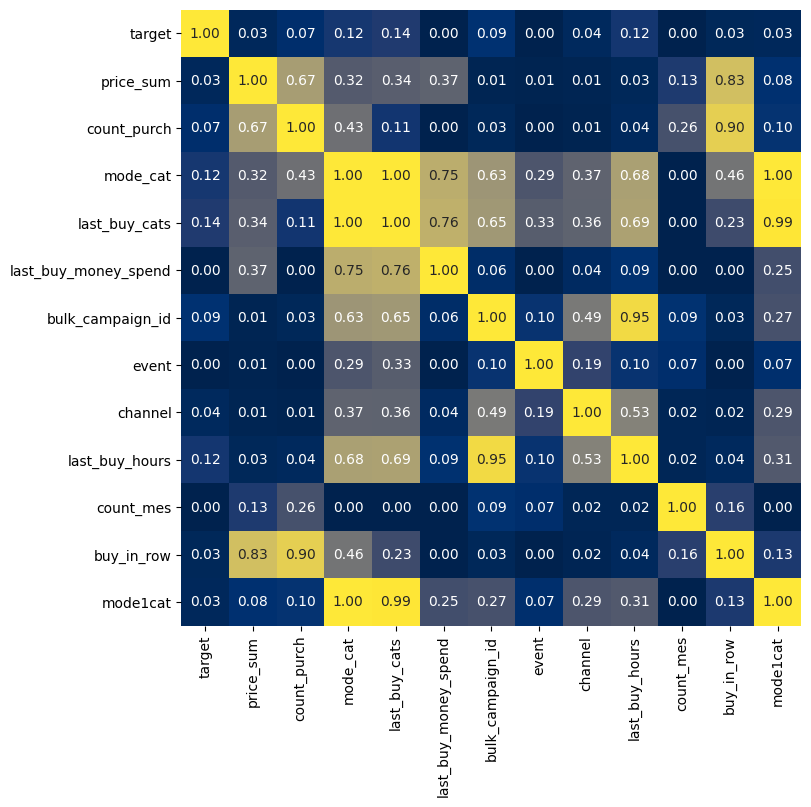

CPU times: total: 2.12 s
Wall time: 48.3 s


In [80]:
%%time
plt.figure(figsize=(8,8))
sns.heatmap(data.drop(columns='client_id').phik_matrix(), annot=True, cmap='cividis', fmt='.2f', cbar=False)
plt.show();

In [81]:
data = data.drop(columns=['mode1cat', 'bulk_campaign_id'])

## Модельки

In [82]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### CatBoost

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             49849 non-null  int64  
 1   target                49849 non-null  int64  
 2   price_sum             49849 non-null  float64
 3   count_purch           49849 non-null  int64  
 4   mode_cat              49849 non-null  object 
 5   last_buy_cats         49849 non-null  object 
 6   last_buy_money_spend  49849 non-null  float64
 7   event                 49849 non-null  object 
 8   channel               49849 non-null  object 
 9   last_buy_hours        49849 non-null  int64  
 10  count_mes             49849 non-null  int64  
 11  buy_in_row            49849 non-null  float64
dtypes: float64(3), int64(5), object(4)
memory usage: 4.9+ MB


In [84]:
cat_features = ['last_buy_cats', 'event', 'channel', 'mode_cat']

In [85]:
Xcb_train, Xcb_test, ycb_train, ycb_test = train_test_split(
    data.drop(['target', 'client_id'], axis=1), 
    data.target, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=data.target
) 

In [86]:
param_grid_cb = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 8, 11],
    'l2_leaf_reg': [1.5, 2.5, 3.5],
    'random_strength': [3, 5, 8],
    'class_weights': [[1, 2.5], [1, 3], [1, 3.5]]
}

In [87]:
model_cb = CatBoostClassifier(
    eval_metric='AUC',
    cat_features=cat_features,
    verbose=False,
    custom_loss='AUC'
)
#model_cb.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=True)

In [88]:
grid_cb = RandomizedSearchCV(
    model_cb,
    param_grid_cb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=10
)

In [89]:
%%time
grid_cb.fit(Xcb_train, ycb_train, eval_set=(Xcb_test, ycb_test))

CPU times: total: 9min 52s
Wall time: 16min 22s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000028D516E3DC0>,
                   n_jobs=-1,
                   param_distributions={'class_weights': [[1, 2.5], [1, 3],
                                                          [1, 3.5]],
                                        'depth': [5, 8, 11],
                                        'iterations': [500, 1000, 1500],
                                        'l2_leaf_reg': [1.5, 2.5, 3.5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'random_strength': [3, 5, 8]},
                   random_state=42, scoring='roc_auc')

In [90]:
print(grid_cb.best_params_, grid_cb.best_score_)

{'random_strength': 3, 'learning_rate': 0.01, 'l2_leaf_reg': 3.5, 'iterations': 1500, 'depth': 5, 'class_weights': [1, 2.5]} 0.6851956334392987


In [91]:
best_model_cb = grid_cb.best_estimator_
y_pred_proba_cb = best_model_cb.predict_proba(Xcb_test)[:, 1]
y_pred_cb = best_model_cb.predict(Xcb_test)
print(f'Метрика roc_auc на тестовой выборке для CatBoost: {roc_auc_score(ycb_test, y_pred_proba_cb)}')

Метрика roc_auc на тестовой выборке для CatBoost: 0.7053633518776078


### Классика

In [92]:
# разбиваем на тренировочную и тестовую выборки
Xcl_train, Xcl_test, ycl_train, ycl_test = train_test_split(
    data.drop(['target', 'client_id'], axis=1),
    data['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify=data['target']
)

In [93]:
ohe_columns = ['event', 'channel']
be_columns = ['last_buy_cats', 'mode_cat']
num_columns = ['price_sum', 'count_purch', 'last_buy_money_spend', 'count_mes', 'buy_in_row', 'last_buy_hours']

In [94]:
ohe_pipe = Pipeline(steps=
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
)

In [95]:
be_pipe = Pipeline(steps=
    [('simpleImputer_be', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('be', BinaryEncoder())]
)

In [96]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('be', be_pipe, be_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [97]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', LogisticRegression())
])

In [98]:
# зададим гиперпараметры и методы масштабирования для каждой модели:
param_grid_cl = [
    # # словарь для модели DecisionTreeClassifier()
    {
        'classifier': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'classifier__max_depth': range(2, 7),
        'classifier__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': range(5, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'classifier': [LogisticRegression(random_state=RANDOM_STATE, 
            solver='lbfgs', penalty='l2', max_iter=500, class_weight='balanced', n_jobs=-1)],
        'classifier__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели RF()
    {
        'classifier': [RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, n_jobs=-1)],
        'classifier__max_depth': range(5,10),
        'classifier__min_samples_split': range(2,5),
        'classifier__min_samples_leaf': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

In [99]:
%%time
# запустим перебор моделей, гиперпараметров и методов масштабирования
grid_cl = RandomizedSearchCV(
    pipe_final, 
    param_grid_cl,
    random_state = RANDOM_STATE,
    cv = 5,
    scoring = 'roc_auc',
    n_jobs = -1,
    n_iter = 30,
    verbose = 2
)

CPU times: total: 0 ns
Wall time: 0 ns


In [100]:
%%time
grid_cl.fit(Xcl_train, ycl_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\ProgramData\anaconda3\envs\practicum\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


CPU times: total: 5.52 s
Wall time: 1min 51s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['event',
                                                                                'channel']),
                                                                              ('be',
                                                                               Pipeline(steps=[('simpleImputer_be...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'classifier': [RandomForestClassifier(n_jobs=-1,
                                                                               random_state=42)],
                                         'classifier__max_depth': range(5, 10),
                                         'classifier__min_samples_leaf': range(2, 5),
                                         'classifier__min_samples_split': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc', verbose=2)

In [101]:
%%time
model_cl = grid_cl.best_estimator_
print('Лучшая модель и её параметры:\n\n', model_cl)
print ('Метрика лучшей модели на тренировочной выборке:', grid_cl.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['event', 'channel']),
                                                 ('be',
                                                  Pipeline(steps=[('simpleImputer_be',
                        

In [102]:
y_pred_proba_cl = model_cl.predict_proba(Xcl_test)[:, 1]
y_pred_cl = model_cl.predict(Xcl_test)
print(f'Метрика roc_auc на тестовой выборке для классической ML: {roc_auc_score(ycl_test, y_pred_proba_cl)}')

Метрика roc_auc на тестовой выборке для классической ML: 0.6941749161417


In [103]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(grid_cl.cv_results_)
display(result[
    ['rank_test_score', 'mean_test_score','params']
].sort_values('rank_test_score')[:10])

,rank_test_score,mean_test_score,params
25,1,0.662346,"{'preprocessor__num': 'passthrough', 'classifier__C': 3, 'classifier': LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1, random_state=42)}"
21,2,0.652699,"{'preprocessor__num': MinMaxScaler(), 'classifier__C': 4, 'classifier': LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1, random_state=42)}"
0,3,0.639930,"{'preprocessor__num': StandardScaler(), 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 5, 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}"
22,4,0.639817,"{'preprocessor__num': StandardScaler(), 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5, 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}"
13,5,0.638549,"{'preprocessor__num': MinMaxScaler(), 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 6, 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}"
19,6,0.637655,"{'preprocessor__num': 'passthrough', 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 9, 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}"
17,7,0.637605,"{'preprocessor__num': MinMaxScaler(), 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 3, 'classifier__max_depth': 7, 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}"
27,8,0.635032,"{'preprocessor__num': MinMaxScaler(), 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 8, 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}"
2,9,0.634658,"{'preprocessor__num': StandardScaler(), 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 3, 'classifier__max_depth': 7, 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}"
16,10,0.633478,"{'preprocessor__num': StandardScaler(), 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 7, 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}"


### LightGBM

In [104]:
data_lgb = data.copy()

In [105]:
le = LabelEncoder()

In [106]:
for i in cat_features:
    data_lgb[i] = le.fit_transform(data_lgb[i])

In [107]:
Xlgb_train, Xlgb_test, ylgb_train, ylgb_test = train_test_split(
    data_lgb.drop(['target', 'client_id'], axis=1), 
    data_lgb.target, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
) 

In [108]:
param_grid_lgb = {
    'num_leaves': [15, 31, 60],
    'learning_rate': [0.01, 0.05, 0.1],
    'lambda_l2': [1, 5, 8],
    'n_estimators': [500, 1000, 1500],
    'min_data_in_leaf': [20, 50, 70],
    'feature_fraction': [0.6, 0.75, 0.9],
    'bagging_fraction': [0.6, 0.75, 0.9],
    'boosting_type': ['gbdt', 'rf']
}

In [109]:
model_lgb = LGBMClassifier(
    objective='binary'
)

In [110]:
grid_lgb = RandomizedSearchCV(
    model_lgb,
    param_grid_lgb,
    cv=3,
    scoring='roc_auc',
    n_jobs = -1,
    n_iter = 25,
    error_score='raise'
)

In [111]:
grid_lgb.fit(Xlgb_train, ylgb_train, eval_set=[(Xlgb_test, ylgb_test)], categorical_feature=cat_features)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=LGBMClassifier(objective='binary'), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.6, 0.75, 0.9],
                                        'boosting_type': ['gbdt', 'rf'],
                                        'feature_fraction': [0.6, 0.75, 0.9],
                                        'lambda_l2': [1, 5, 8],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'min_data_in_leaf': [20, 50, 70],
                                        'n_estimators': [500, 1000, 1500],
                                        'num_leaves': [15, 31, 60]},
                   scoring='roc_auc')

In [112]:
print(grid_lgb.best_params_, grid_lgb.best_score_)

{'num_leaves': 60, 'n_estimators': 1000, 'min_data_in_leaf': 20, 'learning_rate': 0.1, 'lambda_l2': 8, 'feature_fraction': 0.6, 'boosting_type': 'rf', 'bagging_fraction': 0.9} 0.6712884359438198


In [113]:
best_model_lgb = grid_lgb.best_estimator_
y_pred_proba_lgb = best_model_lgb.predict_proba(Xlgb_test)[:, 1]
y_pred_lgb = best_model_lgb.predict(Xlgb_test)
print(f'Метрика roc_auc на тестовой выборке для LightGBM: {roc_auc_score(ylgb_test, y_pred_proba_lgb)}')

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Метрика roc_auc на тестовой выборке для LightGBM: 0.6758432621639648


## Анализ моделей

Итак, мы создали синтетические признаки, отобрали самые подходящие и обучили несколько моделей, а именно CatBoost, LightGBM, а так же несколько других классических моделей (и выбрали лучшую, ей оказалась Логистическая регрессия), кроме того с помощью RandomizedSearchCV перебирали гиперпараметры к данным моделям, чтобы выявить оптимальные модели. Таким образом, целевой показатель в 0.7 по метрике ROC_AUC преодолела только модель CatBoost. Хочется отметить, что при разработке моделей, была проведена проверка модели CatBoost с message_id. Такая модель давала лучшие результаты, но этот признак кореллировал почти со всеми другими, кроме того, есть вероятность некоторой проблемы с данным признаком. Поэтому в конечную модель данный признак не вошёл.

Найдём важность признаков в модели CatBoost

In [114]:
importance = pd.DataFrame()

In [115]:
importance['feature'] = data.drop(columns=['target', 'client_id']).columns

In [116]:
importance['importance'] = best_model_cb.feature_importances_

In [121]:
importance.sort_values('importance', ascending=False)

,feature,importance
7,last_buy_hours,28.081035
4,last_buy_money_spend,12.764777
3,last_buy_cats,12.299894
2,mode_cat,10.759934
8,count_mes,8.877744
0,price_sum,6.816170
1,count_purch,6.292773
5,event,5.417427
6,channel,5.116087
9,buy_in_row,3.574160


In [119]:
explainer = shap.TreeExplainer(best_model_cb)
shap_values = explainer.shap_values(Xcb_train)

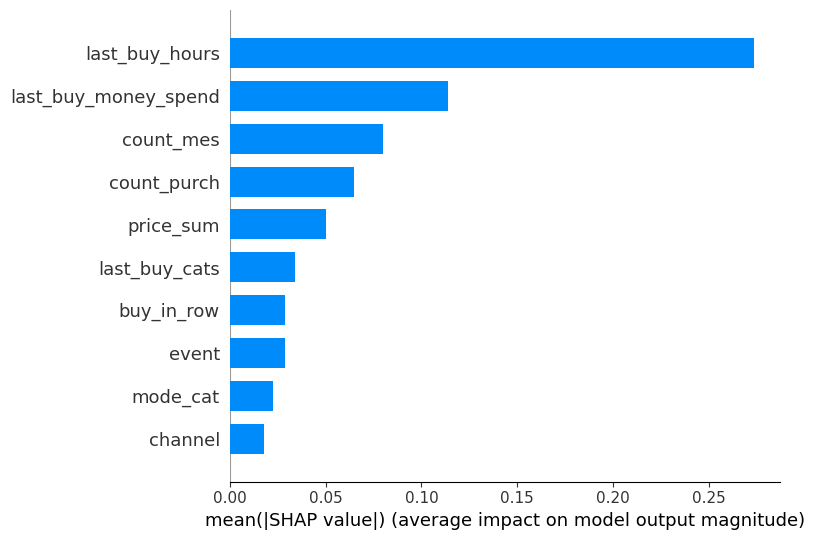

In [120]:
shap.summary_plot(shap_values, Xcb_train, plot_type='bar')

Таким образом, мы определили какие признаки большего всего влияют на решения нашей модели: в первую очередь это то, когда быда совершена последняя покупка и деньги потраченные при последней покупке пользователя.

## Вывод

Целью данного проекта было разработать модель, которая бы предсказывала: Вернётся ли покупатель в ближайшие 90 дней за покупками, с целевым знаечением roc_auc = 0.7. Мы достигли этой цели. Если быть более точными, то в данном проекте изучили данные, разработали полезные признаки, не все синтетические признаки были использованы, но , создали модель для классификации пользователей, лучшей моделью стала CatBoost модель со следующими гиперпараметрами: 'random_strength': 3, 'learning_rate': 0.01, 'l2_leaf_reg': 3.5, 'iterations': 1500, 'depth': 5, 'class_weights': [1, 2.5], кроме того, мы улучшили модель и максимизировали метрику roc_auc с помощью перебора гиперпараметров с использованием RandomizedSearchCV.
Более того, мы вывели важность признаков для данной модели. и получили, что самыми важными признаками является то, когда была совершена последняя покупка и её стоимость.